# Installation

In [1]:
#!pip install scikit-learn
#!pip install opencv-python

# Import

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

import shutil

# Data preparation

The following code moves part of the images from train_data folder (which contains the whole dataset) to test_data folder in order to have a strictly separated test dataset 

In [3]:
# Directories
src_dir = "/Users/lukasiwan/NeueFische/Repositories/Hydroponics/data/train_data"
dst_dir = "/Users/lukasiwan/NeueFische/Repositories/Hydroponics/data/test_data"

# Make sure destination directory exists
os.makedirs(dst_dir, exist_ok=True)

# Proportion of images to use for testing
test_ratio = 0.2

# Seed for reproducibility
np.random.seed(42)

# Counter for tracking moved images
total_moved_images = 0

# For each class directory in the source directory
for class_dir in os.listdir(src_dir):
    if os.path.isdir(os.path.join(src_dir, class_dir)):
        # List all image files in this class directory
        images = os.listdir(os.path.join(src_dir, class_dir))
        
        # Determine the number of images to move
        n_test_images = int(len(images) * test_ratio)
        
        # Select the first n_test_images from each class
        test_images = images[:n_test_images]
        
        # Create a new directory for this class in the destination directory
        os.makedirs(os.path.join(dst_dir, class_dir), exist_ok=True)
        
        # Move the test images to the destination directory if the destination directory is empty
        if len(os.listdir(os.path.join(dst_dir, class_dir))) == 0:
            for image in test_images:
                shutil.move(os.path.join(src_dir, class_dir, image), os.path.join(dst_dir, class_dir, image))
                total_moved_images += 1

# Print the number of images moved
if total_moved_images > 0:
    print(f"Moved {total_moved_images} images from {src_dir} to {dst_dir}.")
else:
    print("No images were moved because the destination directory is not empty.")


No images were moved because the destination directory is not empty.


Preparation of data source for training and setting some parameter. The chosen values for batch_size, image_size and epoch_size are based on testing different combinations.

In [4]:
# Define the directory path containing the images
data_directory = "/Users/lukasiwan/NeueFische/Repositories/Hydroponics/data/train_data"
batch_size = 15
image_size = (50,50)
epoch_size = 15

Splitting the dataset into training and validation (not test!)

In [5]:
# Load and preprocess the data for training set
train_data = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
)

# Load and preprocess the data for validation set
val_data = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation"
)

Found 228 files belonging to 4 classes.
Using 183 files for training.
Found 228 files belonging to 4 classes.
Using 45 files for validation.


Visualisation of class distribution from training and validation data

2023-07-14 14:30:37.787676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:38.016989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:38.418819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:39.439479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:39.465736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


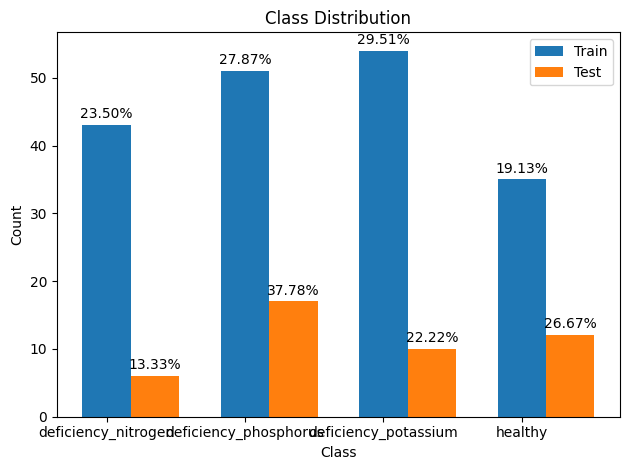

In [6]:
# Get the class names from the training dataset
class_names = train_data.class_names

# Initialize an array to store the class counts
class_counts_train = np.zeros(len(class_names))
class_counts_test = np.zeros(len(class_names))

# Iterate over the training dataset and count the samples in each class
for images, labels in train_data:
    class_counts_train += np.bincount(labels, minlength=len(class_names))

# Iterate over the test dataset and count the samples in each class
for images, labels in val_data:
    class_counts_test += np.bincount(labels, minlength=len(class_names))

# Calculate the total number of samples
total_samples_train = np.sum(class_counts_train)
total_samples_test = np.sum(class_counts_test)

# Create a bar plot of the class distribution for both training and test data
width = 0.35  # width of the bars

fig, ax = plt.subplots()
ax.bar(np.arange(len(class_names)), class_counts_train, width, label='Train')
ax.bar(np.arange(len(class_names)) + width, class_counts_test, width, label='Test')

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Distribution')
ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.legend()

# Add the percentage text above each bar
for i, (train_count, test_count) in enumerate(zip(class_counts_train, class_counts_test)):
    train_percentage = (train_count / total_samples_train) * 100
    test_percentage = (test_count / total_samples_test) * 100

    ax.text(i, train_count + 1, f'{train_percentage:.2f}%', ha='center')
    ax.text(i + width, test_count + 1, f'{test_percentage:.2f}%', ha='center')

plt.tight_layout()
plt.show()

# Modeling

In [7]:
# Define the model architecture
model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

In [8]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [9]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

In [10]:
# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=epoch_size)

Epoch 1/15


2023-07-14 14:30:40.123358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:40.247547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:40.471124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - 2s 85ms/step - loss: 26.4745 - accuracy: 0.2732 - val_loss: 2.4432 - val_accuracy: 0.3333
Epoch 2/15


2023-07-14 14:30:41.629599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:41.643516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:41.795109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:41.920302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:42.134886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - 2s 77ms/step - loss: 1.6788 - accuracy: 0.4044 - val_loss: 1.2489 - val_accuracy: 0.4222
Epoch 3/15


2023-07-14 14:30:43.220084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:43.240702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:43.375219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:43.503654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:43.711770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - 2s 75ms/step - loss: 1.0045 - accuracy: 0.5956 - val_loss: 1.1453 - val_accuracy: 0.4444
Epoch 4/15


2023-07-14 14:30:44.776429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:44.792912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:44.937446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:45.050717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:45.265809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - 2s 73ms/step - loss: 0.6862 - accuracy: 0.7650 - val_loss: 1.0566 - val_accuracy: 0.5111
Epoch 5/15


2023-07-14 14:30:46.324432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:46.341838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:46.484383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:46.613144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:46.846063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - 2s 80ms/step - loss: 0.4621 - accuracy: 0.8689 - val_loss: 0.9060 - val_accuracy: 0.6000
Epoch 6/15


2023-07-14 14:30:47.974940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:47.992506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:48.125875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:48.244434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:48.465862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - 2s 71ms/step - loss: 0.3251 - accuracy: 0.9071 - val_loss: 0.8541 - val_accuracy: 0.6444
Epoch 7/15


2023-07-14 14:30:49.496692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:49.508478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:49.659087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:49.784410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:49.996171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - 2s 73ms/step - loss: 0.1797 - accuracy: 0.9563 - val_loss: 0.8508 - val_accuracy: 0.6444
Epoch 8/15


2023-07-14 14:30:51.059181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:51.071800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:51.215109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:51.337535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:51.557570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - 2s 77ms/step - loss: 0.1064 - accuracy: 0.9891 - val_loss: 0.8921 - val_accuracy: 0.6444
Epoch 9/15


2023-07-14 14:30:52.675702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:52.690909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:52.831699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:52.953462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:53.176900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - 2s 73ms/step - loss: 0.1227 - accuracy: 0.9672 - val_loss: 1.3424 - val_accuracy: 0.5556
Epoch 10/15


2023-07-14 14:30:54.252729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:54.271654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:54.407454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:54.531337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:54.749335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - 2s 74ms/step - loss: 0.0610 - accuracy: 0.9945 - val_loss: 0.7528 - val_accuracy: 0.6889
Epoch 11/15


2023-07-14 14:30:55.817627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:55.834499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:55.985728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:56.118848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:56.325832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - 2s 79ms/step - loss: 0.0249 - accuracy: 1.0000 - val_loss: 0.8120 - val_accuracy: 0.6222
Epoch 12/15


2023-07-14 14:30:57.455610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:57.471228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:57.618984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:57.740379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:57.978740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - 2s 78ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.8819 - val_accuracy: 0.6444
Epoch 13/15


2023-07-14 14:30:59.086616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:59.100678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:59.249835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:59.401488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:30:59.630977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - 2s 84ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.7755 - val_accuracy: 0.7556
Epoch 14/15


2023-07-14 14:31:00.834853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:31:00.845279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:31:00.990439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:31:01.137611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:31:01.457533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - 2s 80ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.7974 - val_accuracy: 0.7333
Epoch 15/15


2023-07-14 14:31:02.604129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:31:02.624264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:31:02.771553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:31:02.907467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:31:03.132206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - 2s 78ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.8820 - val_accuracy: 0.6889


2023-07-14 14:31:04.239817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:31:04.253726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [11]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_data)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

3/3 [==============================] - 0s 5ms/step - loss: 0.8820 - accuracy: 0.6889
Validation Loss: 0.8819843530654907
Validation Accuracy: 0.6888889074325562


2023-07-14 14:31:04.489655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-07-14 14:31:04.504068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [12]:
# Get training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

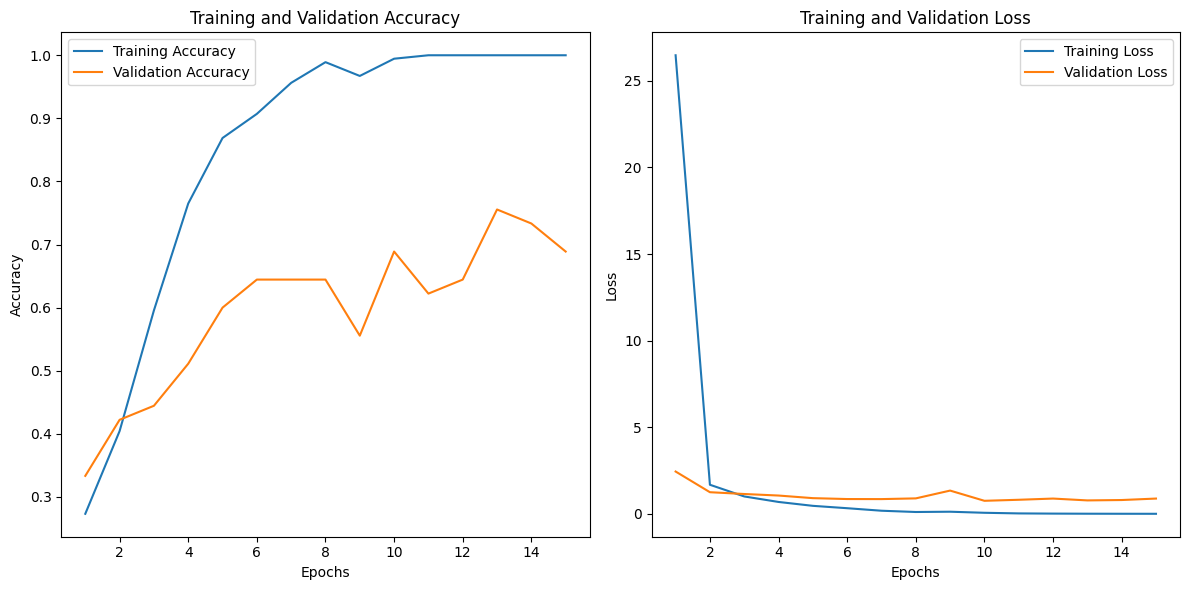

In [13]:
# Get training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Create line plots
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()